**Robinson Foulds (RF) distance** to quantify error between simulated ground-truth and estimated tree 

The assignments of mutational and copy number events to nodes, i.e., their labeling, were obtained by \
the use of `DETOPT`. Here we specifically show how the clonal trees can be unrooted such that the non- \
trivial bipartitions and the RF distance can be computed.

#### **Packages**

In [519]:
import pandas as pd

from graphviz import Digraph
import matplotlib.pyplot as plt
import networkx as nx

from copy import deepcopy
from string import ascii_lowercase

#### **Functions**

In [520]:
def create_graph_from_dict(tree_dict, output_file=''):
    # draw a tree from child parent dictionary
    graph = Digraph('G', format='png')
    
    # node attributes
    graph.attr('node', 
               shape='circle',
               fixedsize='true', 
               width='0.35', 
               height='0.35',
               fontsize='8.75'
               )
    
    # edge attributes
    graph.attr('edge', 
               arrowsize='0.4',
               splines='false'
               )
    
    # convert dictionary, mapping child to parent, to edges
    edges = [(parent, child) for child, parent in tree_dict.items()]

    # add the edges to the graph
    for parent, child in edges:
        graph.edge(parent, child)

    return graph


def create_undirected_graph_from_dict(tree_dict):
    # add nodes/edges to graph, networkx object
    graph = nx.Graph(tree_dict)
    
    # get layout of nodes
    pos = nx.spring_layout(graph)
    
    nx.draw(graph, 
            pos, 
            with_labels=True, 
            node_size=500, 
            node_color='lightgrey', 
            font_family='Arial'
            )
    
    return graph


def create_undirected_graph(graph, pos):    
    # drawing function given graph and layout
    nx.draw(graph, 
            pos, 
            with_labels=True, 
            node_size=500, 
            node_color='lightgrey', 
            font_family='Arial'
            )
    
    return graph


def get_internal_nodes(graph):
    # internal edges have degree > 1
    return [node for node in graph.nodes() if graph.degree(node) > 1]

def get_internal_edges(graph):
    internal_nodes = get_internal_nodes(graph)
    return [(u, v) for (u, v) in graph.edges() \
            if u in internal_nodes and v in internal_nodes]


def extend_internal_nodes_as_leaves(graph, tree_dict):
    internal_nodes = get_internal_nodes(graph)

    for i in internal_nodes:
        if i in tree_dict.keys():
            tree_dict[i] = [tree_dict[i]] + [i+'$']
        else:
            tree_dict[i] = [i+'$']

    return tree_dict


def get_bipartitions(graph):
    internal_edges = get_internal_edges(graph)
    bipartion_set = []

    for edge in internal_edges:
    
        cp_G = deepcopy(graph)
        cp_G.remove_edge(*edge)

        l_bip, r_bip = list(nx.connected_components(cp_G))

        if not len(l_bip) < len(r_bip):

            # stupid, but works
            hold = l_bip
            l_bip = r_bip
            r_bip = hold

        bipartion_set.append(
            f"{''.join(sorted(l_bip))}|{''.join(sorted(r_bip))}"
            )
    
    return bipartion_set

#### **Unrooted tree representation of clonal trees**

**Clonal tree**

In [521]:
TREE_FILE = './simNo_1-s_11-m_100-h_40-cna_0.1.tree.tsv' # example of simulated tree

In [522]:
tree = pd.read_csv(TREE_FILE, sep='\t')
tree_dict = tree.set_index('NODE_ID')['PARENT_ID'].to_dict()

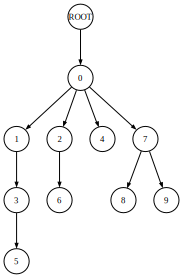

In [523]:
del tree_dict['ROOT']
graph = create_graph_from_dict(tree_dict, '')

graph

Delete the root from the clonal tree since no mutations are assigned to the root node; the root \
represents the subpopulation of normal cells, free of genomic aberrations. Below, we give the \
same tree but with the ROOT removed.

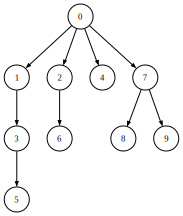

In [524]:
del tree_dict['0']
graph = create_graph_from_dict(tree_dict, '')

graph

**Unrooted tree**

The clonal tree can be represented as an acyclic, undirected graph, i.e., an unrooted tree \
by changing the directed edges into undirected edges. Consider this unrooted tree, as a \
spanning tree on the set of *observed* cancer subclones.

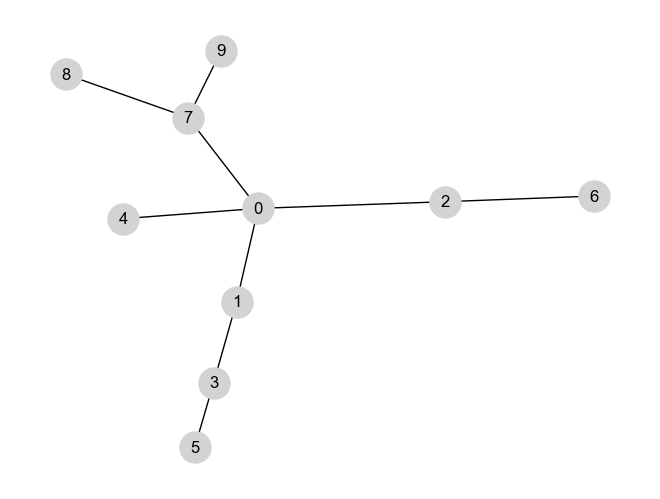

In [525]:
tree_dict_not_ext = deepcopy(tree_dict)
graph = create_undirected_graph_from_dict(tree_dict)

It can easily be seen that we can extend the internal nodes, and respectively their labels, \
 such that each subclone becomes a leaf node in the unrooted tree.

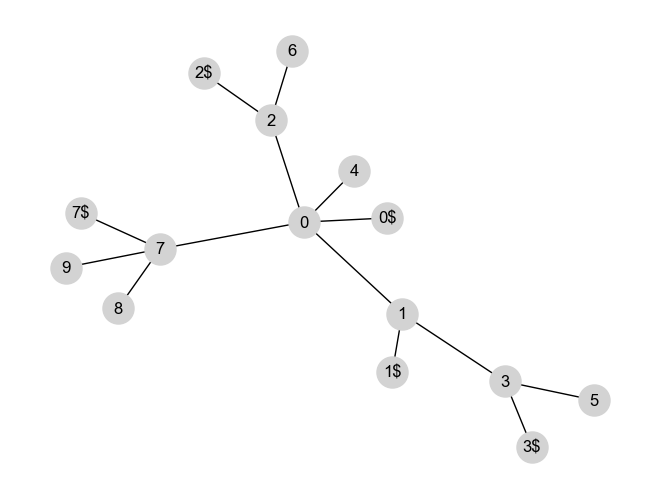

In [505]:
tree_dict_ext = extend_internal_nodes_as_leaves(graph, tree_dict)
ext_graph = create_undirected_graph_from_dict(tree_dict_ext)

Then, we can arbitrarily relabel the internal nodes. Then, to find the non-trivial bipartitions, \
we would just cut each internal edge, e.g., (*b*, *e*), and for each cut, identify the leaf sets of \
the two resultant trees.

In [506]:
internal_nodes = get_internal_nodes(graph)

rename_internal_nodes = dict(zip(internal_nodes, ascii_lowercase))
leaf_labels = map(lambda x: f'{x}$', internal_nodes)
rename_leaf_nodes = dict(zip(leaf_labels, internal_nodes))

rename_internal_nodes.update(rename_leaf_nodes)

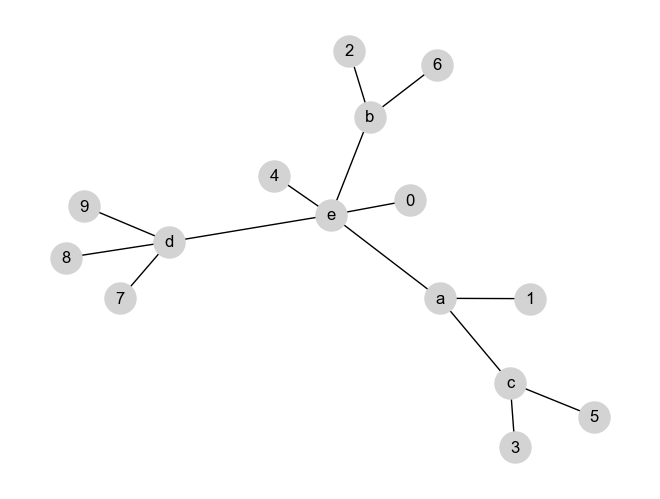

In [507]:
node_mapping = rename_internal_nodes
G_renamed = nx.relabel_nodes(ext_graph, node_mapping)

pos = nx.spring_layout(G_renamed)
full = create_undirected_graph(G_renamed, pos)

#### **Bipartions of (now unrooted) clonal trees**

But it is actually not necessary to extend the internal nodes to leaves to find the tree \
bipartitions. We show an example below; cutting the internal edge (*0*, *1*) in the tree \
below is the same as cutting the internal edge (*a*, *e*) in the tree above.

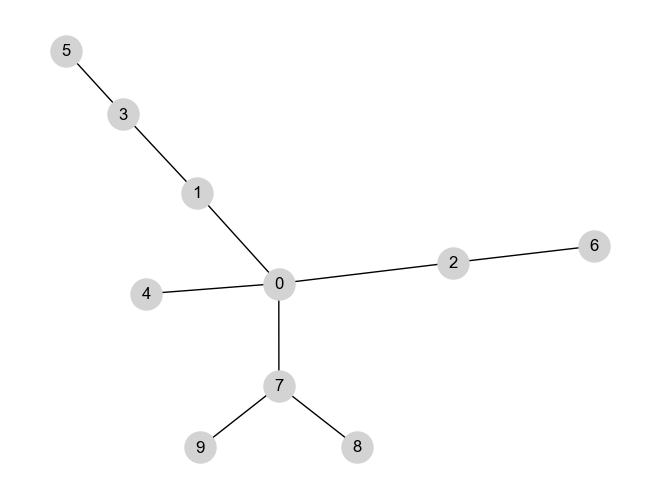

In [533]:
graph = create_undirected_graph_from_dict(tree_dict_not_ext)
cp_G = deepcopy(nx.Graph(tree_dict_not_ext)) # copy of graph

In [527]:
internal_edges = get_internal_edges(graph)

print(internal_edges[0])
cp_G.remove_edge(*internal_edges[0])

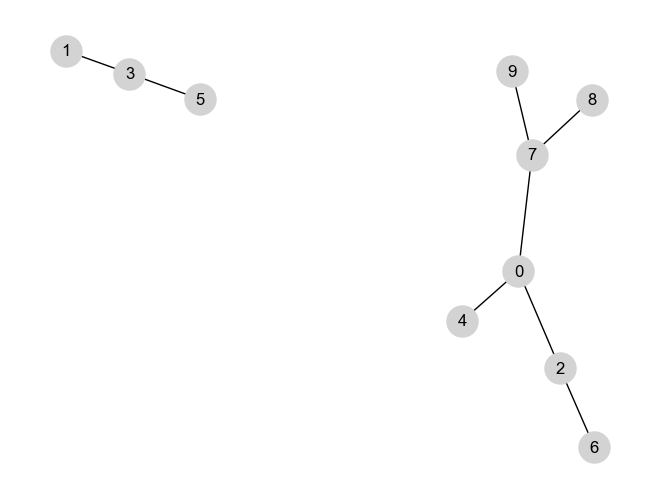

In [530]:
pos = nx.spring_layout(cp_G) 
prev = create_undirected_graph(cp_G, pos)

In [531]:
bipartion_set = get_bipartitions(graph)
bipartion_set

['135|0246789', '35|01246789', '26|01345789', '789|0123456']

#### **`Robinson Foulds` Distance Function**

In [532]:
def robinson_foulds_distance(bip1, bip2):
    # given two bipartition sets from two trees, return the RF distance

    _bip1,_bip2 = set(bip1), set(bip2)
    uniq_bipartitions = _bip1.symmetric_difference(_bip2)

    return len(uniq_bipartitions)